# Cell type classification

---

To disentangle the differences in the chromatin organization and nuclear morphology due to environmental signaling and cell types, a method is needed to transfer cell type information to functionally annotated data. To this end, we hereinafter aim to develop a model that identifies the cell type of PBMC based on their chromatin organization and nuclear morphology.

---

## 0. Environmental setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import os
import matplotlib.pyplot as plt
import tifffile
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statannot import add_stat_annotation
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

import sys
import cv2 as cv

sys.path.append("../../../../..")
from src.utils.notebooks.eda import *

seed = 1234
random.seed(1234)
np.random.seed(1234)

%load_ext nb_black

<IPython.core.display.Javascript object>

---

## 1. Read in data

In [2]:
hv_root_data_dir = "../../../../../data/pbmc_hv/marker/"
feature_file_path = "/preprocessed/full_pipeline/nuclear_features.csv"
qc_result_file_path = "/preprocessed/full_pipeline/segmentation/qc_results.csv"
marker_label_file_path = "/preprocessed/full_pipeline/marker_labels/marker_labels.csv"

<IPython.core.display.Javascript object>

In [3]:
hv_data = read_in_marker_dataset(
    data_dir=hv_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)
hv_data["id"] = hv_data["sample"] + hv_data["timepoint"]

Load data: 100%|██████████| 8/8 [00:00<00:00, 33.76it/s]


<IPython.core.display.Javascript object>

In [4]:
tp1_root_data_dir = "../../../../../data/pbmc_pt/marker/timepoint_1/"
tp2_root_data_dir = "../../../../../data/pbmc_pt/marker/timepoint_2/"
tp3_root_data_dir = "../../../../../data/pbmc_pt/marker/timepoint_3/"

tp1_features = read_in_marker_dataset(
    data_dir=tp1_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)

tp2_features = read_in_marker_dataset(
    data_dir=tp2_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)

tp3_features = read_in_marker_dataset(
    data_dir=tp3_root_data_dir,
    feature_file_path=feature_file_path,
    qc_result_file_path=qc_result_file_path,
    marker_label_file_path=marker_label_file_path,
)

cancer_data = tp1_features.append(tp2_features).append(tp3_features)
cancer_data["id"] = cancer_data["sample"] + cancer_data["timepoint"]

Load data: 100%|██████████| 6/6 [00:00<00:00, 31.32it/s]


<IPython.core.display.Javascript object>

In [5]:
len(hv_data)

2354

<IPython.core.display.Javascript object>

#### Subsample data

In [6]:
np.random.seed(seed)
n_samples = np.min([len(hv_data)] + list(Counter(cancer_data.id).values()))

hv_data = hv_data.iloc[
    np.random.choice(
        list(range(len(hv_data))),
        replace=False,
        size=min(n_samples * len(np.unique(cancer_data.loc[:, "id"])), len(hv_data)),
    )
]
hv_data.describe()

,label,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,...,max_cd4_3d_int,mean_cd4_3d_int,std_cd4_3d_int,q25_cd4_3d_int,q75_cd4_3d_int,median_cd4_3d_int,kurtosis_cd4_3d_int,skewness_cd4_3d_int,cd8,cd4
count,2354.000000,2354.000000,2354.000000,2354.000000,2354.000000,2354.000000,2354.000000,2354.000000,2354.000000,2354.000000,...,2354.000000,2354.000000,2354.000000,2354.0,2354.000000,2354.000000,2354.000000,2354.000000,2354.000000,2354.000000
mean,5.014444,59.303314,73.017842,0.814343,24.937170,37.109434,32.128255,31.882152,25.025858,29.805491,...,41505.861088,3728.960148,4555.434158,0.0,354.745752,1965.703696,95.324986,6.285207,0.165251,0.489805
std,3.225582,4.953307,4.957330,0.071068,3.431073,2.760090,1.866993,1.795780,3.527854,2.129399,...,21932.875534,3505.910668,3911.521653,0.0,392.118108,2027.412004,265.081070,3.518783,0.371486,0.500002
min,1.000000,36.000000,49.000000,0.466667,0.651100,27.790670,20.590717,18.133770,0.651100,12.240607,...,5976.000000,181.854142,447.067188,0.0,43.000000,0.000000,15.427308,3.427292,0.000000,0.000000
25%,2.000000,56.000000,70.000000,0.767123,23.073272,35.297914,30.867415,30.633956,23.085321,28.381163,...,18682.750000,702.056587,1163.871196,0.0,84.000000,106.000000,27.956555,4.694684,0.000000,0.000000
50%,4.000000,59.000000,72.000000,0.819444,25.356186,36.788565,32.006332,31.781185,25.375231,29.866917,...,45540.500000,2330.103293,2993.924270,0.0,160.000000,1272.500000,36.156590,5.153936,0.000000,0.000000
75%,7.000000,63.000000,75.750000,0.869048,27.348310,38.455320,33.274795,32.944055,27.451344,31.169503,...,65535.000000,5734.585490,6967.818937,0.0,510.250000,3251.750000,69.544989,6.660857,0.000000,1.000000
max,18.000000,74.000000,106.000000,0.970588,33.250930,55.205309,40.491774,39.347312,36.991792,37.035699,...,65535.000000,13814.772411,15442.908375,0.0,3380.250000,7754.000000,4647.659451,47.945086,1.000000,1.000000


<IPython.core.display.Javascript object>

In [7]:
sampler = RandomUnderSampler(random_state=seed)
idc = np.array(list(range(len(cancer_data)))).reshape(-1, 1)
sample_idc, _ = sampler.fit_resample(idc, np.array(cancer_data.loc[:, "id"]))
cancer_data = cancer_data.iloc[sample_idc[:, 0]]
cancer_data.describe()

,label,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,...,max_cd4_3d_int,mean_cd4_3d_int,std_cd4_3d_int,q25_cd4_3d_int,q75_cd4_3d_int,median_cd4_3d_int,kurtosis_cd4_3d_int,skewness_cd4_3d_int,cd8,cd4
count,5427.000000,5427.000000,5427.000000,5427.000000,5427.000000,5427.000000,5427.000000,5427.000000,5427.000000,5427.000000,...,5427.000000,5427.000000,5427.000000,5427.0,5427.000000,5427.000000,5427.000000,5427.000000,5427.000000,5427.000000
mean,6.870278,60.771144,79.171181,0.775490,23.878789,40.698231,33.538212,33.254993,23.950549,30.325864,...,25995.629445,1036.244555,1668.220372,0.0,114.892851,383.927492,166.534215,8.407288,0.160678,0.254284
std,5.138672,6.239296,9.399712,0.098667,5.282027,5.475125,2.734729,2.642087,5.331969,2.862511,...,17644.767114,1395.356044,1720.392475,0.0,144.788747,790.715857,409.462172,4.543957,0.367268,0.435498
min,1.000000,19.000000,44.000000,0.195876,0.126352,23.232507,16.925818,15.753451,0.126352,12.217766,...,5550.000000,96.899347,270.349408,0.0,4.000000,0.000000,5.289851,2.553166,0.000000,0.000000
25%,3.000000,57.000000,73.000000,0.718129,21.677940,36.960304,31.703249,31.493163,21.697752,28.613575,...,12266.500000,262.874049,658.832724,0.0,72.000000,26.000000,54.127243,6.083673,0.000000,0.000000
50%,6.000000,61.000000,78.000000,0.791045,24.792772,39.694890,33.332768,33.063739,24.842528,30.404463,...,19186.000000,436.415755,942.304558,0.0,87.000000,56.000000,90.065818,7.606959,0.000000,0.000000
75%,10.000000,65.000000,84.000000,0.848101,27.424510,43.362416,35.293779,34.900305,27.474418,32.190154,...,34667.500000,1213.516862,2061.090975,0.0,116.000000,199.000000,137.814960,9.253107,0.000000,1.000000
max,29.000000,79.000000,178.000000,0.984615,37.103780,127.736559,49.847669,57.812701,38.624851,38.253831,...,65535.000000,23484.122880,23758.320166,0.0,5346.000000,12010.000000,7444.400215,63.895400,1.000000,1.000000


<IPython.core.display.Javascript object>

In [8]:
data = hv_data.append(cancer_data)

<IPython.core.display.Javascript object>

In [9]:
data["cd8_cd4"] = np.repeat("cd8+", len(data))
data.loc[(data["cd8"] == 0) & (data["cd4"] == 1), "cd8_cd4"] = "cd4+"
data.loc[(data["cd8"] == 1) & (data["cd4"] == 1), "cd8_cd4"] = "++"
data.loc[(data["cd8"] == 0) & (data["cd4"] == 0), "cd8_cd4"] = "--"
data.head()

,label,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,...,median_cd4_3d_int,kurtosis_cd4_3d_int,skewness_cd4_3d_int,sample,timepoint,qc_pass,cd8,cd4,id,cd8_cd4
HV1_PBMCs_Dapi_CD8_CD4_28_07_21_2X_16bit_2X_30_1,2,64.0,76.0,0.842105,28.701431,39.775945,33.466759,33.531659,28.701431,31.765103,...,3148.5,29.366770,4.822858,hv1,ctrl,True,0,1,hv1ctrl,cd4+
HV5_PBMCs_Dapi_CD8_CD4_10_09_21_2X_16bit_2X_11_7,8,54.0,73.0,0.739726,21.729859,36.770468,31.634963,30.819654,21.729859,27.758344,...,76.0,452.714683,15.155396,hv5,ctrl,True,0,0,hv5ctrl,--
HV5_PBMCs_Dapi_CD8_CD4_10_09_21_2X_16bit_2X_25_3,4,63.0,70.0,0.900000,27.586776,35.033384,32.370909,32.397846,27.586776,31.409956,...,173.0,55.365317,6.148022,hv5,ctrl,True,1,0,hv5ctrl,cd8+
HV5_PBMCs_Dapi_CD8_CD4_10_09_21_2X_16bit_2X_7_5,6,61.0,67.0,0.910448,27.664185,33.599032,31.217439,31.174702,27.664185,30.488326,...,4388.5,28.341928,4.805751,hv5,ctrl,True,0,1,hv5ctrl,cd4+
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_27_6,7,68.0,80.0,0.850000,29.271972,41.982396,34.141965,34.792148,29.271972,32.603569,...,80.0,42.605397,5.232870,hv4,ctrl,True,0,0,hv4ctrl,--


<IPython.core.display.Javascript object>

---

## 2. Dimensionality reduction

First, we will filter out all features that correspond to the two marker channels as we aim to assess the differences in the chromatin and nuclear morphological organization between different cell types.

In [10]:
data = preprocess_data(data)
sample_labels = data.loc[:, "sample"]
condition_labels = data.loc[:, "timepoint"]
cd8_cd4_label = data.loc[:, "cd8_cd4"]

Nuclei that did not pass the quality check: 308/7781. Remaining: 7473.
Removed 20 constant or features with missing values. Remaining: 262.
Removed additional 6 features. Remaining: 256.


<IPython.core.display.Javascript object>

In [11]:
features = data._get_numeric_data().iloc[:, :-2]
nmco_features = features.copy()
nmco_features = nmco_features.loc[:, ~nmco_features.columns.str.contains("cd8")]
nmco_features = nmco_features.loc[:, ~nmco_features.columns.str.contains("cd4")]
nmco_features.head()

,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,d75_radius,...,rdp_8,rel_dna_3d_int,min_dna_3d_int,max_dna_3d_int,mean_dna_3d_int,std_dna_3d_int,q75_dna_3d_int,median_dna_3d_int,kurtosis_dna_3d_int,skewness_dna_3d_int
HV1_PBMCs_Dapi_CD8_CD4_28_07_21_2X_16bit_2X_30_1,64.0,76.0,0.842105,28.701431,39.775945,33.466759,33.531659,28.701431,31.765103,35.265063,...,0.758546,29662.849420,5581,59448,29662.849420,9408.380695,700.0,29615.0,11.190846,3.434950
HV5_PBMCs_Dapi_CD8_CD4_10_09_21_2X_16bit_2X_11_7,54.0,73.0,0.739726,21.729859,36.770468,31.634963,30.819654,21.729859,27.758344,34.272672,...,0.758281,26344.156256,2967,56539,26344.156256,8451.819450,811.0,26343.0,10.902377,3.384091
HV5_PBMCs_Dapi_CD8_CD4_10_09_21_2X_16bit_2X_25_3,63.0,70.0,0.900000,27.586776,35.033384,32.370909,32.397846,27.586776,31.409956,33.582889,...,0.788160,22586.292518,3047,52776,22586.292518,7058.351766,746.0,22725.0,10.054097,3.273978
HV5_PBMCs_Dapi_CD8_CD4_10_09_21_2X_16bit_2X_7_5,61.0,67.0,0.910448,27.664185,33.599032,31.217439,31.174702,27.664185,30.488326,31.983382,...,0.786378,21685.129834,3113,50802,21685.129834,6940.769463,718.0,21630.0,10.284431,3.294093
HV4_PBMCs_Dapi_CD8_CD4_29_07_21_2X_16bit_2X_27_6,68.0,80.0,0.850000,29.271972,41.982396,34.141965,34.792148,29.271972,32.603569,36.450994,...,0.767493,18245.913928,3604,45511,18245.913928,6640.811662,800.0,17590.0,8.657342,3.019627


<IPython.core.display.Javascript object>

Next, we will remove hihgly correlated features.

In [12]:
nmco_features = remove_correlated_features(nmco_features, threshold=0.8)

Removed 159/214 features with a Pearson correlation above 0.8. Remaining: 55


<IPython.core.display.Javascript object>

In [13]:
nmco_features.describe()

,min_calliper,max_calliper,smallest_largest_calliper,min_radius,med_radius,concavity,area_bbarea,avg_curvature,std_curvature,npolarity_changes,...,moments_normalized-2-0,moments_central-0-1,moments_central-1-0,moments_hu-6,equivalent_diameter.1,extent,rel_hc_volume,rdp_1,q75_dna_3d_int,kurtosis_dna_3d_int
count,7473.000000,7473.000000,7473.000000,7473.000000,7473.000000,7473.000000,7473.000000,7473.000000,7473.000000,7473.000000,...,7473.000000,7.473000e+03,7.473000e+03,7.473000e+03,7473.000000,7473.000000,7473.000000,7473.000000,7473.000000,7473.000000
mean,60.453901,77.285294,0.789116,24.341750,33.150321,0.046427,0.726537,0.026425,0.054119,53.107186,...,0.083799,-2.720362e-13,-1.062001e-13,-1.376846e-08,37.978088,0.445667,0.077239,0.003562,727.698950,12.052981
std,5.739672,8.624713,0.091915,4.658177,2.478469,0.026607,0.047227,0.002743,0.012066,11.456201,...,0.017311,1.355950e-11,2.882872e-11,1.074192e-06,1.876948,0.057243,0.006640,0.003899,157.834238,2.957628
min,19.000000,44.000000,0.195876,0.126352,16.925818,0.013411,0.270013,-0.013368,0.020999,25.000000,...,0.026767,-8.742518e-11,-1.609237e-10,-6.421493e-05,16.052892,0.138536,0.000000,0.000006,44.000000,4.145671
25%,57.000000,71.000000,0.739130,22.320180,31.413025,0.030232,0.703680,0.024759,0.044983,46.000000,...,0.073123,-7.801759e-12,-1.861622e-11,-3.447697e-12,36.874554,0.413133,0.073332,0.000627,631.000000,10.271599
50%,60.000000,75.000000,0.802632,25.062896,32.857626,0.039474,0.733039,0.026764,0.053428,52.000000,...,0.081668,-2.984279e-13,0.000000e+00,8.721029e-19,37.569293,0.453938,0.077542,0.002308,718.000000,11.612390
75%,64.000000,82.000000,0.857143,27.448155,34.604910,0.053755,0.757812,0.028209,0.061907,59.000000,...,0.091902,7.560175e-12,1.835332e-11,3.104436e-12,38.851537,0.485116,0.081446,0.005209,813.000000,13.413197
max,79.000000,178.000000,0.984615,37.103780,49.847669,0.414248,0.848692,0.044214,0.126469,170.000000,...,0.345764,7.537437e-11,1.364242e-10,2.108691e-05,48.553175,0.622596,0.108720,0.038862,1585.000000,76.881305


<IPython.core.display.Javascript object>

---

## 3. Data visualization

In [14]:
nmco_features_sc = pd.DataFrame(
    StandardScaler().fit_transform(nmco_features),
    index=nmco_features.index,
    columns=nmco_features.columns,
)

<IPython.core.display.Javascript object>

In [15]:
tsne = TSNE(random_state=seed)
tsne_embs = tsne.fit_transform(nmco_features_sc)
tsne_embs = pd.DataFrame(
    tsne_embs, columns=["tsne_0", "tsne_1"], index=nmco_features_sc.index
)
tsne_embs.loc[:, "sample"] = np.array(data.loc[tsne_embs.index, "sample"])
tsne_embs.loc[:, "timepoint"] = np.array(data.loc[tsne_embs.index, "timepoint"])
tsne_embs.loc[:, "cd8_cd4"] = np.array(data.loc[tsne_embs.index, "cd8_cd4"])

<IPython.core.display.Javascript object>

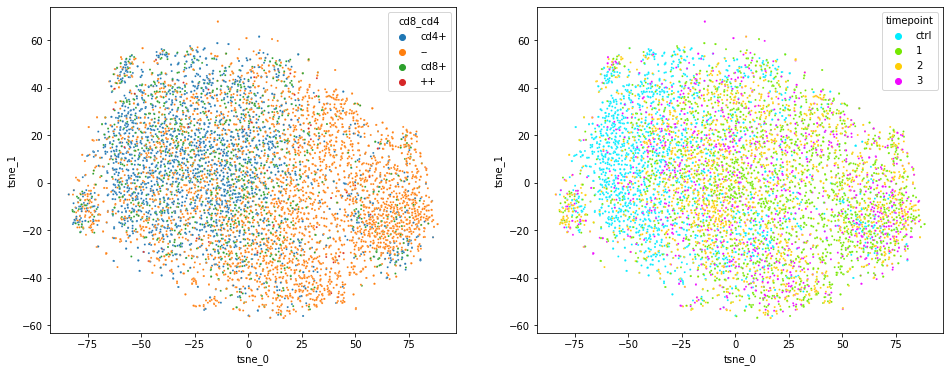

<IPython.core.display.Javascript object>

In [16]:
fig, ax = plt.subplots(figsize=[16, 6], ncols=2)
ax = ax.flatten()
ax[0] = sns.scatterplot(
    data=tsne_embs, x="tsne_0", y="tsne_1", hue="cd8_cd4", ax=ax[0], s=4
)
ax[1] = sns.scatterplot(
    data=tsne_embs,
    x="tsne_0",
    y="tsne_1",
    hue="timepoint",
    ax=ax[1],
    palette="gist_ncar",
    s=4,
)

---

## 4. Classification




#### CD4 data

In [17]:
sampler = RandomUnderSampler(random_state=seed)
idc = np.array(list(range(len(nmco_features_sc)))).reshape(-1, 1)
cd4_idc, _ = sampler.fit_resample(idc, data.loc[nmco_features_sc.index, "cd4"])

cd4_data = nmco_features.iloc[cd4_idc[:, 0]]
cd4_labels = data.loc[cd4_data.index, "cd4"]
cd4_data.describe()

,min_calliper,max_calliper,smallest_largest_calliper,min_radius,med_radius,concavity,area_bbarea,avg_curvature,std_curvature,npolarity_changes,...,moments_normalized-2-0,moments_central-0-1,moments_central-1-0,moments_hu-6,equivalent_diameter.1,extent,rel_hc_volume,rdp_1,q75_dna_3d_int,kurtosis_dna_3d_int
count,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,...,4950.000000,4.950000e+03,4.950000e+03,4.950000e+03,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000,4950.000000
mean,60.212929,76.377576,0.794700,24.478917,32.948488,0.044073,0.729832,0.026730,0.052588,52.773737,...,0.083373,-2.601455e-13,4.958253e-13,6.260120e-09,37.885453,0.451878,0.076790,0.003610,731.576061,11.793948
std,5.572744,8.194510,0.089301,4.569506,2.389135,0.025310,0.045777,0.002548,0.011795,11.195363,...,0.016337,1.352108e-11,2.805793e-11,3.451456e-07,1.717034,0.056343,0.006662,0.003912,154.029113,2.593895
min,31.000000,49.000000,0.357143,0.126352,18.372191,0.013411,0.394138,0.007409,0.020999,25.000000,...,0.036968,-8.742518e-11,-1.222702e-10,-5.265353e-06,25.930339,0.138536,0.000000,0.000006,117.000000,4.145671
25%,56.000000,71.000000,0.746479,22.469321,31.259678,0.029022,0.708471,0.025302,0.043657,46.000000,...,0.073145,-7.926104e-12,-1.767653e-11,-2.556424e-12,36.882043,0.422983,0.072838,0.000688,635.000000,10.136539
50%,60.000000,74.000000,0.807692,25.180198,32.660132,0.036845,0.736319,0.027105,0.051644,51.000000,...,0.081526,-2.131628e-13,7.247536e-13,-3.267600e-17,37.525943,0.460692,0.077016,0.002398,722.500000,11.386687
75%,64.000000,80.000000,0.861111,27.478844,34.315700,0.050537,0.759725,0.028417,0.060148,58.000000,...,0.091373,7.643663e-12,1.894218e-11,2.081304e-12,38.535502,0.489211,0.081052,0.005171,813.000000,13.090865
max,79.000000,127.000000,0.984615,37.103780,43.457435,0.351536,0.848692,0.044214,0.126469,170.000000,...,0.307688,7.537437e-11,1.155058e-10,2.108691e-05,48.553175,0.594352,0.101006,0.027514,1585.000000,29.355802


<IPython.core.display.Javascript object>

#### CD8 data

In [18]:
sampler = RandomUnderSampler(random_state=seed)
idc = np.array(list(range(len(nmco_features_sc)))).reshape(-1, 1)
cd8_idc, _ = sampler.fit_resample(idc, data.loc[nmco_features_sc.index, "cd8"])

cd8_data = nmco_features.iloc[cd8_idc[:, 0]]
cd8_labels = data.loc[cd8_data.index, "cd8"]
cd8_data.describe()

,min_calliper,max_calliper,smallest_largest_calliper,min_radius,med_radius,concavity,area_bbarea,avg_curvature,std_curvature,npolarity_changes,...,moments_normalized-2-0,moments_central-0-1,moments_central-1-0,moments_hu-6,equivalent_diameter.1,extent,rel_hc_volume,rdp_1,q75_dna_3d_int,kurtosis_dna_3d_int
count,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,...,2452.000000,2.452000e+03,2.452000e+03,2.452000e+03,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000,2452.000000
mean,60.343393,76.441272,0.795480,24.612345,33.000739,0.044131,0.729367,0.026632,0.053190,52.544861,...,0.083300,-3.741999e-13,5.306323e-14,4.600094e-09,37.933519,0.451138,0.077410,0.003615,733.800367,11.900377
std,5.551909,7.961467,0.089012,4.312214,2.387824,0.023931,0.043893,0.002461,0.011807,11.004210,...,0.016103,1.302150e-11,2.744980e-11,2.422662e-07,1.723615,0.054017,0.006787,0.003869,153.264138,2.632326
min,35.000000,58.000000,0.394231,0.651100,21.880020,0.015592,0.394138,0.010761,0.020999,26.000000,...,0.038181,-7.432277e-11,-1.041656e-10,-5.265353e-06,19.846368,0.138536,0.000000,0.000006,77.000000,4.145671
25%,57.000000,71.000000,0.744186,22.652584,31.311163,0.029455,0.706443,0.025186,0.044205,46.000000,...,0.073426,-7.592149e-12,-1.832845e-11,-3.167402e-12,36.901806,0.421146,0.073685,0.000705,640.750000,10.209295
50%,60.000000,75.000000,0.808824,25.211579,32.759398,0.038042,0.735365,0.026957,0.052417,51.000000,...,0.081657,-5.400125e-13,-2.486900e-14,-1.486683e-15,37.592282,0.458223,0.077844,0.002418,722.000000,11.561318
75%,64.000000,80.000000,0.861111,27.495167,34.381023,0.050720,0.758682,0.028247,0.060867,58.000000,...,0.090982,7.332801e-12,1.730172e-11,1.793100e-12,38.777060,0.488228,0.081541,0.005333,814.000000,13.305732
max,78.000000,127.000000,0.984615,36.970107,43.457435,0.349159,0.843084,0.039864,0.114686,170.000000,...,0.229566,5.673684e-11,1.121805e-10,8.170609e-06,47.691920,0.594352,0.100280,0.027514,1585.000000,57.098185


<IPython.core.display.Javascript object>

---

### Nuclei-level split

At first we will assess the performance of a RandomForest classifier evaluated on a balanced subset of the data that is split in a stratified way on the nuclei-level, i.e. nuclei from different conditions, individuals and time points will be included in the training and validation data. We assess the performance of the classifier using 10-fold cross-validation and computing the ROC-AUC.

#### CD4

In [19]:
features = np.array(cd4_data)
labels = np.array(cd4_labels)

<IPython.core.display.Javascript object>

In [20]:
rfc = RandomForestClassifier(n_estimators=500, n_jobs=10, random_state=seed)
skf = StratifiedKFold(10)


confusion_mtx = np.zeros([2, 2])
for train_index, test_index in skf.split(features, labels):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    rfc.fit(X_train, y_train)
    confusion_mtx += confusion_matrix(y_test, rfc.predict(X_test), normalize="true")
confusion_mtx /= 10

<IPython.core.display.Javascript object>

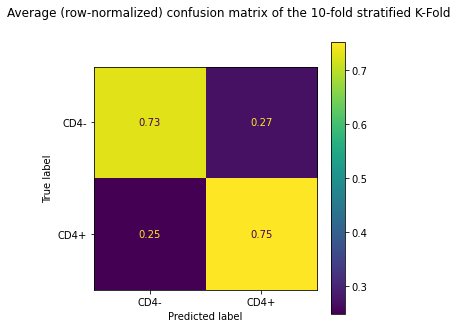

<IPython.core.display.Javascript object>

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(
    confusion_mtx,
    display_labels=["CD4-", "CD4+"],
)
disp.plot(ax=ax)
fig.suptitle(
    "Average (row-normalized) confusion matrix of the 10-fold stratified K-Fold"
)
plt.show()

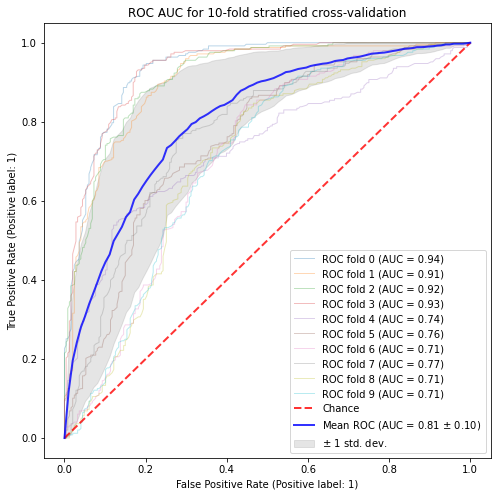

<IPython.core.display.Javascript object>

In [22]:
plot_roc_for_stratified_cv(
    features,
    labels,
    10,
    rfc,
    "ROC AUC for 10-fold stratified cross-validation",
    pos_label=1,
)
plt.show()

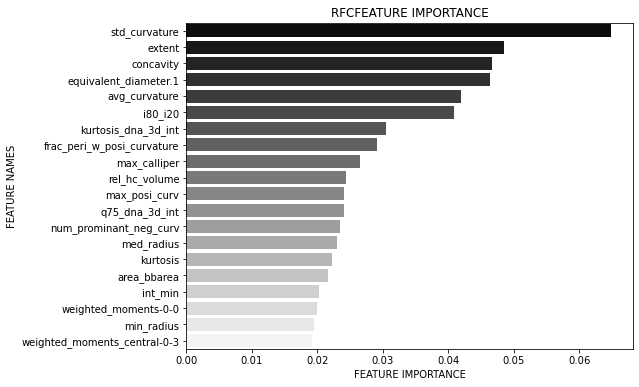

<IPython.core.display.Javascript object>

In [23]:
rfc = rfc.fit(features, labels)
plot_feature_importance(rfc.feature_importances_, cd4_data.columns, "RFC")

---

#### CD8

In [24]:
features = np.array(cd8_data)
labels = np.array(cd8_labels)

<IPython.core.display.Javascript object>

In [25]:
rfc = RandomForestClassifier(n_estimators=500, n_jobs=10, random_state=seed)
skf = StratifiedKFold(10)


confusion_mtx = np.zeros([2, 2])
for train_index, test_index in skf.split(features, labels):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    rfc.fit(X_train, y_train)
    confusion_mtx += confusion_matrix(y_test, rfc.predict(X_test), normalize="true")
confusion_mtx /= 10

<IPython.core.display.Javascript object>

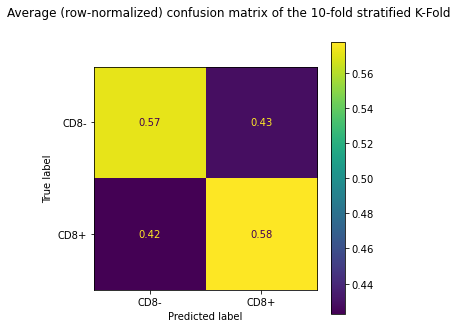

<IPython.core.display.Javascript object>

In [26]:
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(
    confusion_mtx,
    display_labels=["CD8-", "CD8+"],
)
disp.plot(ax=ax)
fig.suptitle(
    "Average (row-normalized) confusion matrix of the 10-fold stratified K-Fold"
)
plt.show()

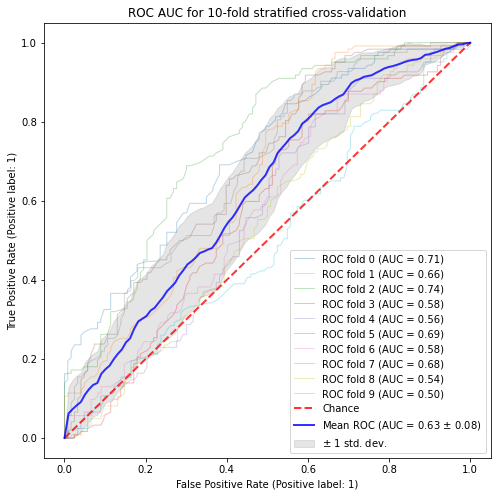

<IPython.core.display.Javascript object>

In [27]:
plot_roc_for_stratified_cv(
    features,
    labels,
    10,
    rfc,
    "ROC AUC for 10-fold stratified cross-validation",
    pos_label=1,
)
plt.show()

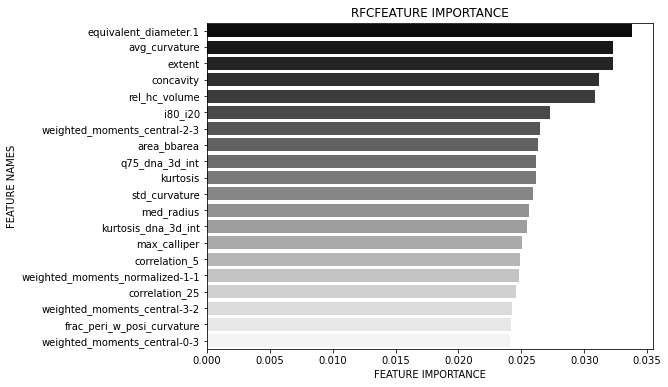

<IPython.core.display.Javascript object>

In [28]:
rfc = rfc.fit(features, labels)
plot_feature_importance(rfc.feature_importances_, cd8_data.columns, "RFC")

---

### Sample split

#### CD4

In [29]:
features = np.array(cd4_data)
labels = np.array(cd4_labels)

<IPython.core.display.Javascript object>

In [30]:
from sklearn.model_selection import GroupKFold

sample_labels = np.array(data.loc[cd4_data.index, "sample"])

gkf = GroupKFold(n_splits=10)

confusion_mtx = np.zeros([2, 2])
for train_index, test_index in gkf.split(features, labels, groups=sample_labels):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    rfc.fit(X_train, y_train)
    confusion_mtx += confusion_matrix(y_test, rfc.predict(X_test), normalize="true")
confusion_mtx /= 10

<IPython.core.display.Javascript object>

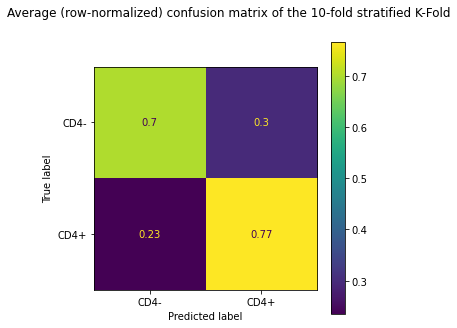

<IPython.core.display.Javascript object>

In [31]:
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(
    confusion_mtx,
    display_labels=["CD4-", "CD4+"],
)
disp.plot(ax=ax)
fig.suptitle(
    "Average (row-normalized) confusion matrix of the 10-fold stratified K-Fold"
)
plt.show()

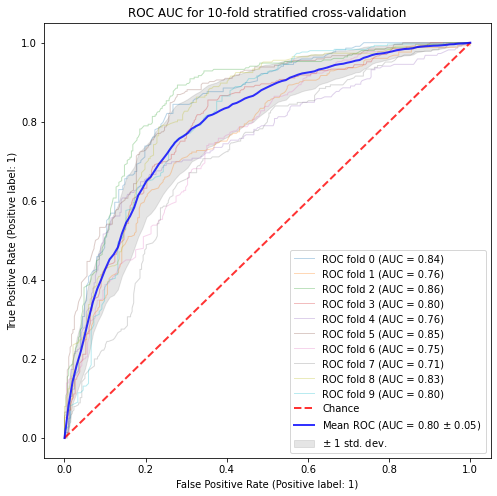

<IPython.core.display.Javascript object>

In [32]:
plot_roc_for_stratified_cv(
    features,
    labels,
    10,
    rfc,
    "ROC AUC for 10-fold stratified cross-validation",
    pos_label=1,
    groups=sample_labels,
)
plt.show()

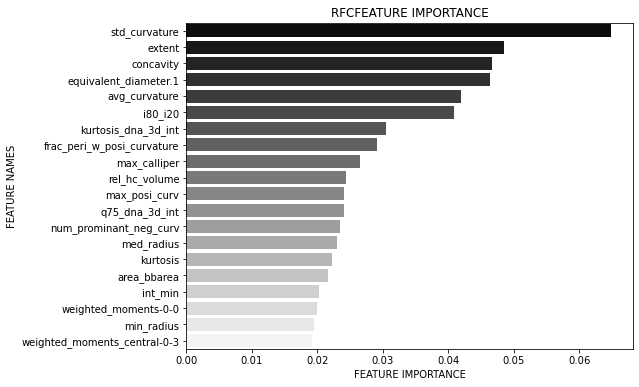

<IPython.core.display.Javascript object>

In [33]:
rfc = rfc.fit(features, labels)
plot_feature_importance(rfc.feature_importances_, cd4_data.columns, "RFC")

---
#### CD8

In [34]:
features = np.array(cd8_data)
labels = np.array(cd8_labels)

<IPython.core.display.Javascript object>

In [35]:
sample_labels = np.array(data.loc[cd8_data.index, "sample"])

gkf = GroupKFold(n_splits=10)

confusion_mtx = np.zeros([2, 2])
for train_index, test_index in gkf.split(features, labels, groups=sample_labels):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    rfc.fit(X_train, y_train)
    confusion_mtx += confusion_matrix(y_test, rfc.predict(X_test), normalize="true")
confusion_mtx /= 10

<IPython.core.display.Javascript object>

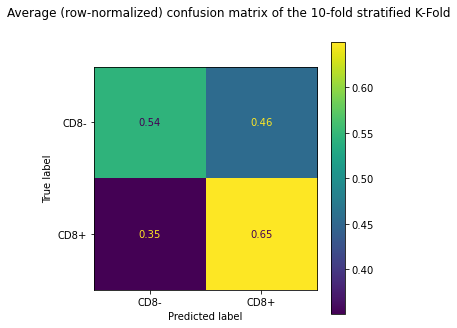

<IPython.core.display.Javascript object>

In [36]:
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(
    confusion_mtx,
    display_labels=["CD8-", "CD8+"],
)
disp.plot(ax=ax)
fig.suptitle(
    "Average (row-normalized) confusion matrix of the 10-fold stratified K-Fold"
)
plt.show()

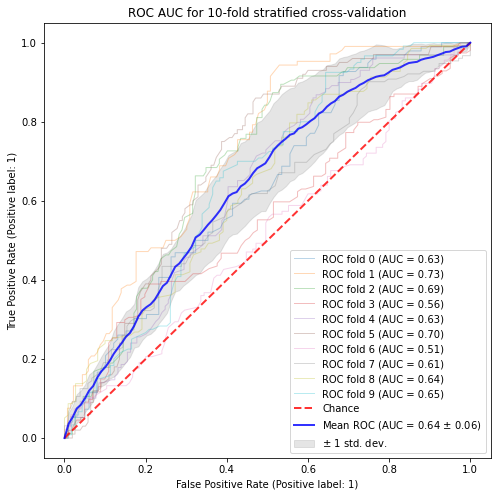

<IPython.core.display.Javascript object>

In [37]:
plot_roc_for_stratified_cv(
    features,
    labels,
    10,
    rfc,
    "ROC AUC for 10-fold stratified cross-validation",
    pos_label=1,
    groups=sample_labels,
)
plt.show()

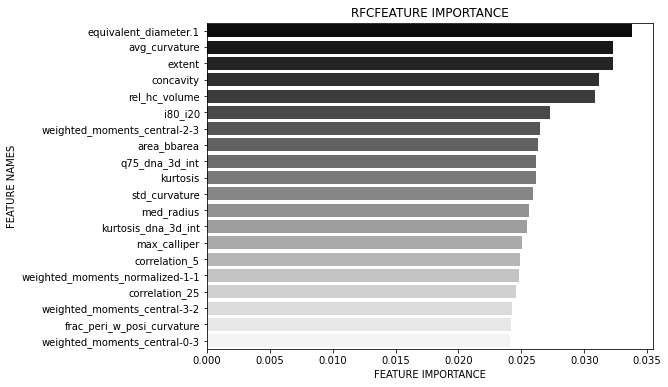

<IPython.core.display.Javascript object>

In [38]:
rfc = rfc.fit(features, labels)
plot_feature_importance(rfc.feature_importances_, cd8_data.columns, "RFC")

---

### Timepoint split

#### CD4

In [39]:
features = np.array(cd4_data)
labels = np.array(cd4_labels)

<IPython.core.display.Javascript object>

In [40]:
from sklearn.model_selection import GroupKFold

tp_labels = np.array(data.loc[cd4_data.index, "timepoint"])

gkf = GroupKFold(n_splits=4)

confusion_mtx = np.zeros([2, 2])
for train_index, test_index in gkf.split(features, labels, groups=tp_labels):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    rfc.fit(X_train, y_train)
    confusion_mtx += confusion_matrix(y_test, rfc.predict(X_test), normalize="true")
confusion_mtx /= 4

<IPython.core.display.Javascript object>

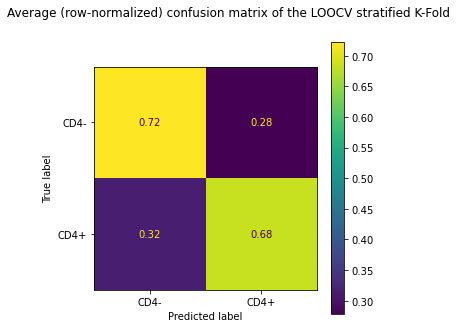

<IPython.core.display.Javascript object>

In [41]:
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(
    confusion_mtx,
    display_labels=["CD4-", "CD4+"],
)
disp.plot(ax=ax)
fig.suptitle("Average (row-normalized) confusion matrix of the LOOCV stratified K-Fold")
plt.show()

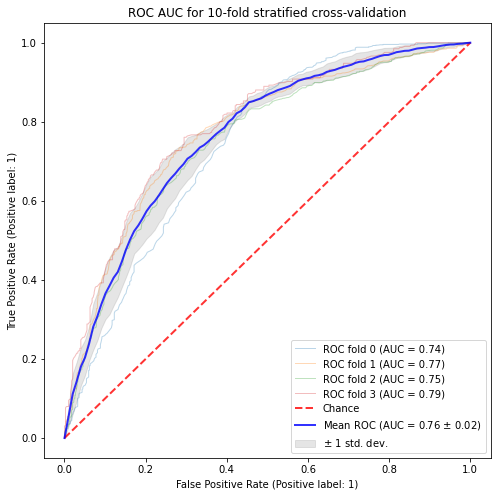

<IPython.core.display.Javascript object>

In [42]:
plot_roc_for_stratified_cv(
    features,
    labels,
    4,
    rfc,
    "ROC AUC for 10-fold stratified cross-validation",
    pos_label=1,
    groups=tp_labels,
)
plt.show()

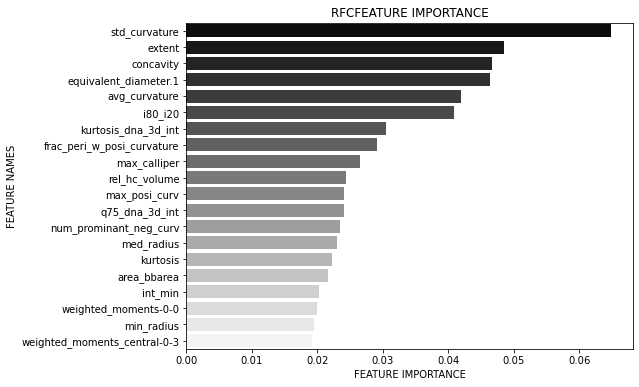

<IPython.core.display.Javascript object>

In [43]:
rfc = rfc.fit(features, labels)
plot_feature_importance(rfc.feature_importances_, cd4_data.columns, "RFC")

___

#### CD8

In [44]:
features = np.array(cd8_data)
labels = np.array(cd8_labels)

<IPython.core.display.Javascript object>

In [45]:
from sklearn.model_selection import GroupKFold

tp_labels = np.array(data.loc[cd8_data.index, "timepoint"])

gkf = GroupKFold(n_splits=4)

confusion_mtx = np.zeros([2, 2])
for train_index, test_index in gkf.split(features, labels, groups=tp_labels):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    rfc.fit(X_train, y_train)
    confusion_mtx += confusion_matrix(y_test, rfc.predict(X_test), normalize="true")
confusion_mtx /= 4

<IPython.core.display.Javascript object>

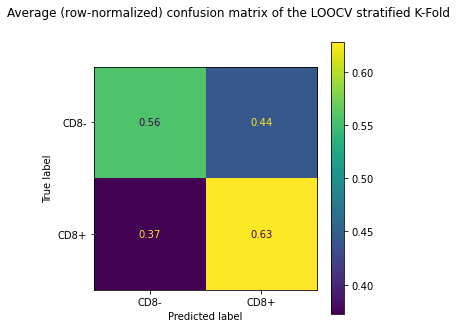

<IPython.core.display.Javascript object>

In [46]:
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(
    confusion_mtx,
    display_labels=["CD8-", "CD8+"],
)
disp.plot(ax=ax)
fig.suptitle("Average (row-normalized) confusion matrix of the LOOCV stratified K-Fold")
plt.show()

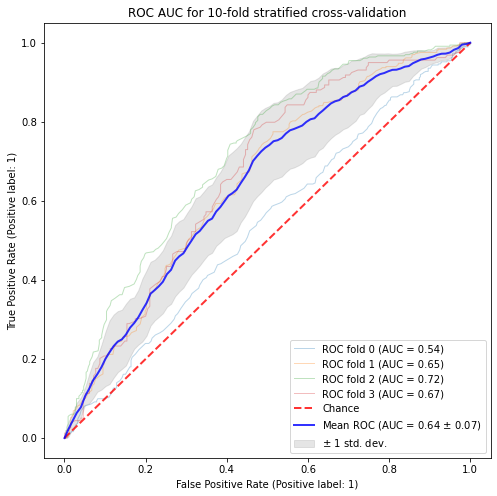

<IPython.core.display.Javascript object>

In [47]:
plot_roc_for_stratified_cv(
    features,
    labels,
    4,
    rfc,
    "ROC AUC for 10-fold stratified cross-validation",
    pos_label=1,
    groups=tp_labels,
)
plt.show()

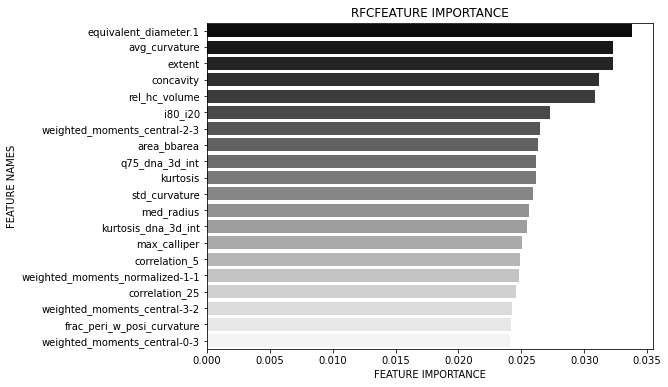

<IPython.core.display.Javascript object>

In [48]:
rfc = rfc.fit(features, labels)
plot_feature_importance(rfc.feature_importances_, cd8_data.columns, "RFC")